### Import all necessary libraries

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler,LabelEncoder
from scipy import stats
from sklearn.cluster import KMeans
from scipy.stats import zscore
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/IIITD Projects/Machine Learning/Project 2/renttherunway.csv', index_col=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      192544 non-null  int64  
 1   fit             192544 non-null  object 
 2   user_id         192544 non-null  int64  
 3   bust size       174133 non-null  object 
 4   item_id         192544 non-null  int64  
 5   weight          162562 non-null  object 
 6   rating          192462 non-null  float64
 7   rented for      192534 non-null  object 
 8   review_text     192482 non-null  object 
 9   body type       177907 non-null  object 
 10  review_summary  192199 non-null  object 
 11  category        192544 non-null  object 
 12  height          191867 non-null  object 
 13  size            192544 non-null  int64  
 14  age             191584 non-null  float64
 15  review_date     192544 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 23.5+ 

In [5]:
df.duplicated().sum()

0

In [6]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [7]:
to_remove = ['Unnamed: 0','review_date','user_id','item_id', 'review_text','review_summary']
df.drop(columns=to_remove,inplace=True)

- Let's rename a few feature names for for ease-of-access in pandas.
- I also make sure that bust size is renamed as 'bra_size' which is what the column values stand for. 

In [8]:
df.rename(columns={'bust size':'bra_size','rented for':'rented_for','body type':'body_type'}, inplace=True)

In [9]:
def missing_data(df):
  missing_data = pd.DataFrame({'net_missing': df.isnull().sum(), '%missing': (df.isnull().sum()/len(df))*100})
  print(missing_data)

missing_data(df)

            net_missing   %missing
fit                   0   0.000000
bra_size          18411   9.561970
weight            29982  15.571506
rating               82   0.042588
rented_for           10   0.005194
body_type         14637   7.601899
category              0   0.000000
height              677   0.351608
size                  0   0.000000
age                 960   0.498587


- There are ample number of missing values in our data. 
- We need to do a little EDA to get a sense of the data before we can go ahead with missing value inputation. 
- An idea of outliers will also be helpful. Let us observe the data manually first.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,192462.0,9.092371,1.430044,2.0,8.0,10.0,10.0,10.0
size,192544.0,12.245175,8.494877,0.0,8.0,12.0,16.0,58.0
age,191584.0,33.871017,8.058083,0.0,29.0,32.0,37.0,117.0


- There are three numerical features. Let's create a list for them.

In [11]:
num_features = ['rating','size','age']

**rating**
- rating goes from 2 to 10. 
- It has a few mising values. We will impute them based on data. 
- I would love to choose them based on the review text, but depends. Not many missing values. 
- I don't think there are outliers.

**size**
- It is the standardized size of the product
- size ranges from 0 to 58 
- mean is almost equal to median, signifying a normal distribution. 
- It was chosen by the customer, but labelled by the company.
- As it's a rent company, customers don't have the freedom to 'change' their size. And they can only 'choose.
- So, all sizes are valid. This column looks consistent, as it should. 
- But we will still check for outliers.

**age**
- age ranges from 0 to 117, which is obviously unreasonable.
- I will first check the customers who have put their age less than 15, and then those who have over 90, and check other values.
- It is reasonable to assume that some customers are private and they do not wish to share their details. But it still doesn't make sense for one to put their age as 117.


*Let me analyze the data based on boxplots.*

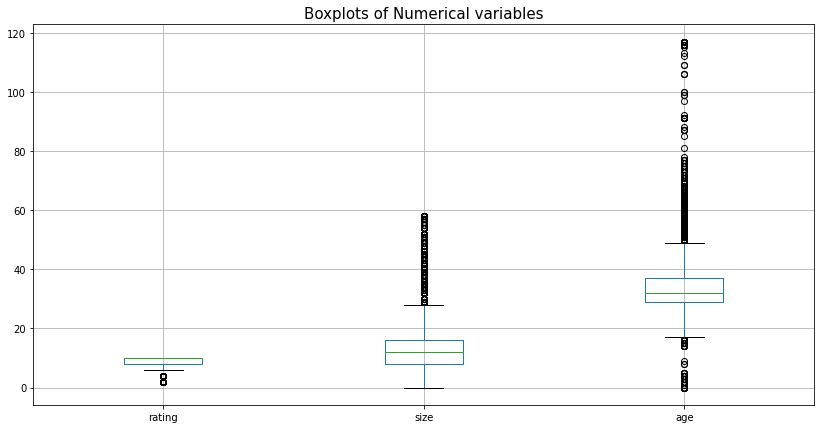

In [12]:
plt.figure(figsize=(14,7))
df[num_features].boxplot()
plt.title("Boxplots of Numerical variables", fontsize=15)
plt.show()

- First I will deal with 'age'
- Clearly there are too many outliers in this column, as I has expected. Let's first check the customers who put their age over 100

In [13]:
df[df.age >= 100]

,fit,bra_size,weight,rating,rented_for,body_type,category,height,size,age
2,fit,NaN,NaN,10.0,party,NaN,sheath,"5' 4""",4,116.0
10445,small,32d,105lbs,10.0,party,petite,dress,"5' 0""",4,117.0
13393,fit,32c,115lbs,10.0,formal affair,athletic,dress,"5' 2""",4,116.0
18013,fit,32d,105lbs,10.0,formal affair,petite,sheath,"5' 0""",1,117.0
19960,small,32a,127lbs,8.0,everyday,pear,dress,"5' 4""",12,116.0
...,...,...,...,...,...,...,...,...,...,...
180838,fit,32b,NaN,10.0,wedding,athletic,gown,"5' 4""",4,117.0
182102,fit,NaN,115lbs,10.0,wedding,hourglass,sheath,NaN,4,100.0
185087,fit,34b,NaN,10.0,formal affair,hourglass,gown,"5' 1""",12,117.0
190312,fit,34aa,127lbs,8.0,wedding,NaN,sheath,"5' 4""",12,112.0


In [14]:
df[df.age >= 100].describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fit,67,3,fit,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bra_size,58,16,32d,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,48,15,115lbs,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,67.0,NaN,NaN,NaN,9.253731,1.197767,4.0,8.0,10.0,10.0,10.0
rented_for,67,6,party,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_type,64,7,hourglass,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,67,8,dress,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,66,11,"5' 4""",16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,67.0,NaN,NaN,NaN,10.776119,11.213927,0.0,4.0,8.0,16.0,51.0
age,67.0,NaN,NaN,NaN,115.328358,3.783489,100.0,116.0,117.0,117.0,117.0


- What is funny about this subset is that almost all the ratings are either 10 or 8. I think that these are fakes entries put in order to better the ratings.
- I will remove all these rows from the dataset.

In [15]:
df.drop(df[df['age'] >= 100].index, inplace = True)

- Let's check for the subset of ages over 90 also, just to be sure.

In [16]:
df[df.age >= 90].describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fit,20,3,fit,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bra_size,20,4,34a,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,20,4,110lbs,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,20.0,NaN,NaN,NaN,8.5,1.572795,6.0,8.0,8.0,10.0,10.0
rented_for,20,6,everyday,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_type,20,3,petite,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,20,8,dress,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,20,3,"5' 3""",16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,20.0,NaN,NaN,NaN,4.05,2.543826,1.0,1.75,4.0,4.75,8.0
age,20.0,NaN,NaN,NaN,92.15,2.70039,91.0,91.0,91.0,91.0,99.0


- Mean is 8.5 with almost all the values ranging from 8 to 10.
- Let's check for ages over 85

In [17]:
df[df.age >= 85].describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fit,26,3,fit,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bra_size,25,6,34a,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,26,8,110lbs,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,26.0,NaN,NaN,NaN,8.461538,1.529203,6.0,8.0,8.0,10.0,10.0
rented_for,26,7,everyday,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_type,26,5,petite,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,26,9,dress,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,26,7,"5' 3""",16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,26.0,NaN,NaN,NaN,5.884615,4.794388,1.0,3.25,4.0,8.0,20.0
age,26.0,NaN,NaN,NaN,90.923077,3.30966,85.0,91.0,91.0,91.0,99.0


- Once again, a similar trend.
- I think, it would be safe to drop all those customers who have reported their age to be over 85.
- There is no significant data loss compared to the outliers (customers) we will get rid of.

In [18]:
df.drop(df[df['age'] >= 85].index, inplace = True)

- Now let's check for ages less than 10

In [19]:
df[df.age <= 10]

,fit,bra_size,weight,rating,rented_for,body_type,category,height,size,age
2029,fit,34b,125lbs,10.0,other,straight & narrow,dress,"5' 7""",4,0.0
6495,large,NaN,130lbs,8.0,other,NaN,dress,"5' 6""",8,3.0
8947,fit,NaN,145lbs,8.0,party,athletic,gown,"5' 9""",13,3.0
11515,fit,34b,125lbs,10.0,wedding,straight & narrow,maxi,"5' 7""",4,0.0
14737,fit,36c,180lbs,10.0,party,pear,dress,"5' 10""",28,2.0
...,...,...,...,...,...,...,...,...,...,...
171302,fit,NaN,NaN,10.0,wedding,full bust,dress,"4' 11""",8,0.0
171996,fit,38d,250lbs,10.0,wedding,pear,gown,"5' 5""",45,3.0
175266,fit,34c,135lbs,10.0,formal affair,athletic,jacket,"5' 4""",8,5.0
176984,fit,34d,155lbs,10.0,party,hourglass,skirt,"5' 6""",14,0.0


- Little kids are not supposed to have 'bust_size' of 32 or 38
- Almost all are rated 10
- Should be removed.
- Lets' check for age 10 to 15. Ideally we should remove them before looking because the company has options only for girls characterize as teens, which is over 15 if we go extreme.

In [20]:
df[(df.age >= 10) & (df.age <= 15)].describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fit,26,3,fit,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bra_size,21,11,34a,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,23,15,145lbs,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,26.0,NaN,NaN,NaN,9.538462,1.30325,4.0,10.0,10.0,10.0,10.0
rented_for,26,5,formal affair,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_type,21,5,athletic,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,26,5,dress,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,25,10,"5' 5""",6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,26.0,NaN,NaN,NaN,10.307692,10.387567,1.0,4.0,8.0,13.75,51.0
age,26.0,NaN,NaN,NaN,14.730769,0.452344,14.0,14.25,15.0,15.0,15.0


- Similar trend of suspiciously high ratings. I will remove them.


In [21]:
df.drop(df[df['age'] <= 15].index, inplace = True)

- Let's be sure, and check the data between 15 to 18 once

In [22]:
df[(df.age >= 15) & (df.age <= 18)].describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fit,558,3,fit,439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bra_size,500,33,34b,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,488,54,130lbs,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,558.0,NaN,NaN,NaN,9.311828,1.239492,2.0,8.0,10.0,10.0,10.0
rented_for,558,8,formal affair,315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_type,484,7,athletic,157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,558,13,gown,248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,555,16,"5' 6""",87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,558.0,NaN,NaN,NaN,8.734767,6.613563,0.0,4.0,8.0,12.0,39.0
age,558.0,NaN,NaN,NaN,17.560932,0.636175,16.0,17.0,18.0,18.0,18.0


- Customers of this age segment have given a mean rating of 9.3, which is still considerable. But I will keep them.
- FFake customers can be attacked in a different way.
- Now, let's see 'size' once again.
- In America, where the company is located, the sizes range from 0 to 22, with no odd values. That is also the case on the website of renttherunway.
- But we observed that size values range upto 58 in this dataset. This is quite confusing. 
- So I check on its countplot to check the counts of possible sizes in this dataset

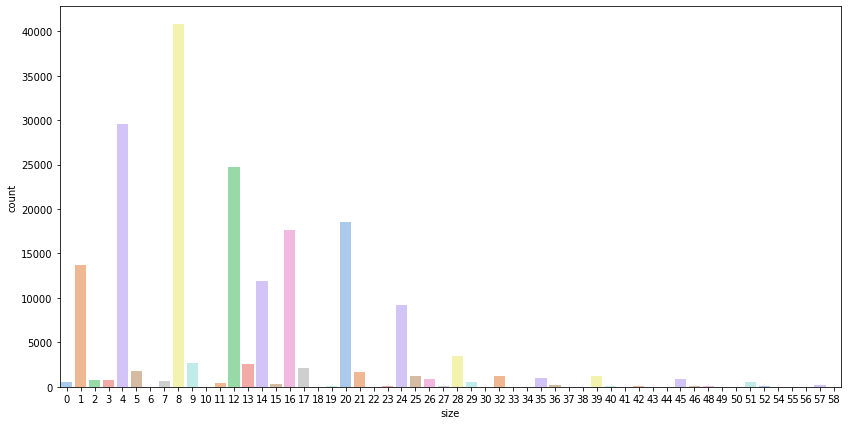

In [23]:
plt.figure(figsize=(14,7))
sns.countplot(data=df,x='size', palette='pastel')
plt.show()

- Too many customers have sizes as odd. So, I think the data has already been processed, and the values have been given a different range.
- The odd values cannot be explained even if consider that the sizes are a mix of American and European size possible value of dress size.
- Let me still have a glance of the customers who have a size over 28.

In [24]:
df[df['size']>28].describe().T

,count,mean,std,min,25%,50%,75%,max
rating,6328.0,9.017699,1.482313,2.0,8.0,10.0,10.0,10.0
size,6329.0,39.125612,7.500349,29.0,32.0,39.0,45.0,58.0
age,6289.0,36.669105,9.081344,16.0,30.0,34.0,41.0,76.0


- There are over 6000 customers who have size greater than 26. A significant value.
- Most of them have rated highly (mean=9)
- age as well as size is normally distributed.
- I don't think I am going to do anything about it. It requires intervention of an expert who can explain what these values mean.
- For now, I am going to take this as it is. 
- Let me convert rating scale to 1-5: There are only even numbers (i.e. 2, 4, 6, 8, 10) so condensing it to this scale seems reasonable.

In [25]:
df['rating'] = df['rating']/2

In [26]:
df[['age','rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
age,191401.0,33.847953,7.863566,16.0,29.0,32.0,37.0,81.0
rating,192279.0,4.546092,0.715087,1.0,4.0,5.0,5.0,5.0


- Before going further, I will impute the age and rating by their median (which are almost same as mean) because I wish to preserver their integral integrity.

In [27]:
df['age'].fillna(df['age'].median(), inplace=True)
df['rating'].fillna(df['rating'].median(), inplace=True)

- Let's have a glance of the data once again

In [28]:
df.sample(15)

,fit,bra_size,weight,rating,rented_for,body_type,category,height,size,age
78121,fit,34b,118lbs,5.0,party,athletic,shift,"5' 3""",1,34.0
71330,large,34d,150lbs,4.0,everyday,hourglass,top,"5' 5""",8,36.0
94368,fit,36c,NaN,5.0,date,hourglass,dress,"5' 8""",20,33.0
160204,fit,34d,150lbs,5.0,wedding,hourglass,dress,"5' 6""",16,30.0
91726,fit,32c,100lbs,3.0,other,petite,dress,"5' 2""",4,45.0
97751,small,34c,122lbs,4.0,other,athletic,gown,"5' 4""",8,31.0
106918,fit,34c,135lbs,5.0,everyday,hourglass,top,"5' 4""",12,29.0
117751,fit,NaN,NaN,5.0,wedding,full bust,dress,"5' 9""",24,29.0
20603,fit,32c,125lbs,5.0,formal affair,athletic,gown,"5' 7""",5,38.0
27481,fit,36dd,153lbs,5.0,date,athletic,sheath,"5' 3""",24,50.0


- Let's focus on weight and height of the customers.
- First we will remove, the lbs part from the weight feature values, keeping in mind that around 15% of them are missing.
- The we will convert the height in ft-inch to inch, keeping the values in inches for it's an American dataset.
- Then I will convert the data type of these features to numeric.

In [29]:
# In the following command, I have extracted all the numerics (0-9) using extract method of string object
#we also convert it into numeric by using pandas' to_numeric method
df["weight"] = df["weight"].str.extract("([0-9]+)", expand=True).apply(pd.to_numeric)

In [30]:
# function to convert height into inches
# let height stand for the feature-column of the variable height in the dataframe
def to_inch(height):
  #extracting the numerical strings from the height values (of the form FT'IN'')
  height = height.str.extractall("([0-9]+)").reset_index()
  #the above function removes the ' and '' from the values and saves the two remaining numbers in height Series
  #creating two  new Series objects by extracting the fiest and second values stored in height Series
  # we use boolean filter using index values to achieve this. 
  feet = (height["match"] == 0)
  inch = (height["match"] == 1)
  #converting the feet and inch into numeric and multiplying feet by 12
  feet_changed = height[feet].drop(["level_0", "match"], axis=1).reset_index(drop=True).apply(pd.to_numeric) * 12
  inch_changed = height[inch].drop(['level_0','match'], axis=1).reset_index(drop=True).apply(pd.to_numeric)
  #adding the converted featrures and return them 
  return feet_changed + inch_changed

#running the function on the height column
df['height']=to_inch(df['height'])

In [31]:
df.sample(15)

,fit,bra_size,weight,rating,rented_for,body_type,category,height,size,age
46322,fit,34b,148.0,4.0,formal affair,hourglass,dress,62.0,16,28.0
20305,fit,34c,120.0,4.0,wedding,pear,gown,67.0,4,26.0
60259,small,36c,NaN,5.0,vacation,hourglass,romper,67.0,14,58.0
86112,large,36c,NaN,5.0,other,hourglass,jacket,69.0,12,24.0
12847,large,34c,135.0,5.0,everyday,athletic,cardigan,62.0,4,27.0
84666,fit,32a,120.0,5.0,wedding,athletic,sheath,62.0,1,29.0
44523,large,32b,125.0,5.0,date,athletic,dress,68.0,8,28.0
61031,fit,34b,140.0,5.0,party,hourglass,gown,67.0,9,43.0
152056,large,34c,129.0,1.0,party,straight & narrow,dress,66.0,8,37.0
103203,large,34d,145.0,5.0,party,hourglass,jumpsuit,63.0,8,27.0


- Now let us check the height and weight values to see if they make sense.
- First we check their boxplots.

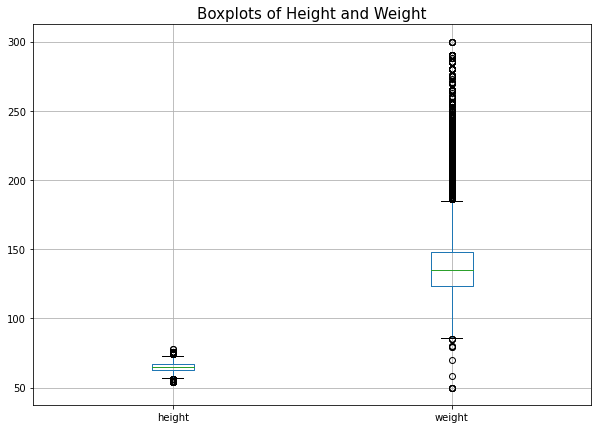

In [32]:
plt.figure(figsize=(10,7))
df[['height','weight']].boxplot()
plt.title("Boxplots of Height and Weight", fontsize=15)
plt.show()

In [33]:
df[['height','weight','age']].describe().T

,count,mean,std,min,25%,50%,75%,max
height,191504.0,65.310798,2.663449,54.0,63.0,65.0,67.0,78.0
weight,162410.0,137.400394,21.898560,50.0,123.0,135.0,148.0,300.0
age,192361.0,33.838730,7.845000,16.0,29.0,32.0,37.0,81.0


**weight**
- From the boxplots, we felt that there are too many outliers in the weight column. But mean is almost equal to median, pointing towards a usual distribution of weights in a sample of population
- The average weight of the customers is 137 pounds, and the weights range from 50 to 300 pounds, with significant people lying in the weight range 135 to 148 (as seen in the third quartile.
- Everything looks consistent to me.
- And I will impute the null value with median.

In [34]:
df['weight'].fillna(df['weight'].median(), inplace=True)

**height**
- height ranges from 54 to 78 inches, which seems reasonable for a sample human population
- the mean height of the given set of customers is almost same as median, indicating the presence of a normal distribution.
- I will impute the null values with mean

In [35]:
df['height'].fillna(df['height'].median(), inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192361 entries, 0 to 192543
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fit         192361 non-null  object 
 1   bra_size    173982 non-null  object 
 2   weight      192361 non-null  float64
 3   rating      192361 non-null  float64
 4   rented_for  192351 non-null  object 
 5   body_type   177736 non-null  object 
 6   category    192361 non-null  object 
 7   height      192361 non-null  float64
 8   size        192361 non-null  int64  
 9   age         192361 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 20.2+ MB


- We have seen the numeric features.
- Let's focus on the categorical ones.

**bra_size**
- First try to understand how many types of values are present

In [37]:
df['bra_size'].value_counts()

34b    27272
34c    23129
34d    18024
36c    13508
32d    11172
       ...  
28h        1
46f        1
42j        1
28i        1
44h        1
Name: bra_size, Length: 106, dtype: int64

- There are 106 types of bra sizes found in the customer dataset we have
- Each bra size, as the nomenclature is, is given by two numeric digits followed by an alphabetic character.
- The numeric digits correspond to the band size, and alphabetic characters correspond to the bust/cup size.
- Now, looking at the data we have, most of the customers have a band size of 34, which is the case worldwide. So, the data values are consistent.
- We can impute the values with mode of the all the possible customer values

In [38]:
df['bra_size'].fillna(df['bra_size'].mode()[0], inplace=True)

- I am going to split this column into two different columns
  - There are too many possible classes (106)
  - The algorithms I am going to use to cluster are centroid based, and do not perform well when there are too many categorical features

**body_type**
- We can already see that we have to impute missing values in this column with mode.
- But let us still be sure

In [39]:
df['body_type'].value_counts()

hourglass            55294
athletic             43641
pear                 22105
petite               22095
full bust            14996
straight & narrow    14730
apple                 4875
Name: body_type, dtype: int64

- There are seven classes. Most of the customers chose to go for a body hugging dress as is clear from their choice of hourglass, athletic or pear. 
- We will impute the missing values with mode. And I might choose to 'reduce' the number of classes by considering one or two classes as same. 

In [40]:
df['body_type'].fillna(df['body_type'].mode()[0], inplace=True)

Let us perform mode imputation with rented_for as well.

In [41]:
df['rented_for'].fillna(df['rented_for'].mode()[0], inplace=True)

In [42]:
missing_data(df)

            net_missing  %missing
fit                   0       0.0
bra_size              0       0.0
weight                0       0.0
rating                0       0.0
rented_for            0       0.0
body_type             0       0.0
category              0       0.0
height                0       0.0
size                  0       0.0
age                   0       0.0


Thus, missing value imputation has been done. Let us check the distribution of all the features for a final glimpse before going ahead with EDA and feature engineering

In [43]:
df.columns

Index(['fit', 'bra_size', 'weight', 'rating', 'rented_for', 'body_type',
       'category', 'height', 'size', 'age'],
      dtype='object')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192361 entries, 0 to 192543
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fit         192361 non-null  object 
 1   bra_size    192361 non-null  object 
 2   weight      192361 non-null  float64
 3   rating      192361 non-null  float64
 4   rented_for  192361 non-null  object 
 5   body_type   192361 non-null  object 
 6   category    192361 non-null  object 
 7   height      192361 non-null  float64
 8   size        192361 non-null  int64  
 9   age         192361 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 20.2+ MB


- weight, rating, height age are in float64, but they are not decimal numbers. So we can reduce the space occupied by them by converting them into int. 
- Let's do it. 

- Now, we are ready to go ahead with EDA, feature engineering and processing.
- I will save the data in a new dataframe, and conntinue with the process in a separate page to make the entire thing more readable, and avoid refreshing and computing the values again and again.

In [49]:
df1 = df

In [50]:
df.to_csv('cleaned1_renttherunway.csv')

## Data preprocessing

### Q13. Encode the categorical features in the dataset and apply data standardization.

In [ ]:
df_cat = df.select_dtypes(include='object')
#df_cat = df_cat.replace(to_replace ="?",value ="Private")

In [ ]:
## Label encoding
le = LabelEncoder()
for col in df_cat:
    df[col] = le.fit_transform(df[col])

In [ ]:
## Standardization
df1 = df.copy()
scaled_features = StandardScaler().fit_transform(df1.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)

In [ ]:
scaled_features_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,-0.989465,-0.220328,0.415027,-2.316842,-1.130972,0.889969,0.059056,0.959288,-1.899033,0.699510,-0.153686,-0.214674,-0.043987,0.253553,-0.562683
1,-0.041839,-0.220328,-0.965577,0.201763,-0.384866,-0.446803,-0.453188,-0.901884,0.400515,0.699510,-0.153686,-0.214674,0.780671,0.253553,-0.562683
2,-0.770782,-1.239283,1.525140,-0.805679,0.734292,-0.446803,1.083546,-0.901884,0.400515,0.699510,-0.153686,-0.214674,-0.043987,0.253553,1.777199
3,0.395526,-0.220328,-0.254967,1.209204,-0.011814,-0.446803,0.059056,-0.901884,-1.899033,0.699510,0.707694,-0.214674,-0.043987,0.253553,1.777199
4,-1.499726,-0.220328,-0.827676,1.209204,-0.011814,0.889969,-0.709311,0.959288,0.400515,-1.429572,-0.153686,-0.214674,-0.868646,0.253553,-0.562683


## Principal Component Analysis.

### Q14. Apply PCA to reduce dimensionality of the dataset.

In [ ]:
## Calculating covariance matrix
cov_matrix = np.cov(scaled_features_df.T)
print('Covariance matrix','\n',cov_matrix)

Covariance matrix 
 [[ 1.00049505e+00  9.15276998e-02 -8.44182057e-02 -9.03575710e-02
  -2.27608225e-02 -2.77385746e-01 -2.69467915e-02 -2.59748396e-01
   1.20771077e-02  6.76969032e-02  7.95460244e-02  5.14831433e-02
   6.43394289e-02  2.89572373e-02  2.06116489e-01]
 [ 9.15276998e-02  1.00049505e+00 -2.24837159e-02  7.20451556e-02
   8.00069658e-02 -5.33132312e-02  2.63254956e-02 -7.95766286e-02
   4.82695598e-02  5.21701189e-02  4.51658533e-02  2.27081776e-02
   8.35674445e-02  8.23059323e-03  6.71745501e-02]
 [-8.44182057e-02 -2.24837159e-02  1.00049505e+00  1.56944047e-03
  -4.25729441e-02  4.63336124e-02 -1.90743361e-02 -3.35947821e-03
  -6.53773751e-03  2.02176063e-02  2.84153785e-03 -1.81121235e-02
   8.63769198e-03 -4.33633510e-02  9.25437720e-04]
 [-9.03575710e-02  7.20451556e-02  1.56944047e-03  1.00049505e+00
   3.86539697e-01 -3.18953899e-02 -3.15288774e-02 -2.16124048e-02
  -9.31342988e-03 -1.30681501e-03  4.76332819e-02  4.35894295e-02
   4.11241019e-02  7.39584533e-02  

In [ ]:
## Calculating eigen values and eigen vectors
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen vectors:','\n',eig_vecs)
print('\n')
print('Eigen values:','\n',eig_vals)

Eigen vectors: 
 [[ 2.57638184e-01  2.15084959e-01  2.96608763e-01 -2.97518919e-02
   5.83893563e-01  4.20724458e-01  4.05495931e-01  7.21606316e-02
  -2.36309819e-01  7.60791813e-02 -2.14514662e-01 -8.35587442e-03
   5.64344177e-02  4.66618724e-03 -9.35068030e-04]
 [ 1.46997855e-01 -7.65056793e-02 -1.65597464e-02 -2.76000059e-04
   8.77703785e-02 -1.63024285e-01 -9.98714641e-02 -1.54071745e-02
  -3.79857203e-02  6.78197689e-02  8.80032599e-02 -4.65361336e-01
   7.89620755e-01 -2.52651711e-01  1.00448778e-01]
 [-3.14572954e-02  4.06703693e-02  1.93712888e-02 -6.18206497e-02
  -3.87824922e-01  6.33032248e-02  3.33912768e-02  1.26856310e-01
  -5.30674154e-02  1.15961737e-01 -6.22865801e-01 -2.71360525e-01
   1.61619732e-01  4.84030131e-01 -2.88563043e-01]
 [ 1.22120499e-01 -5.31503847e-01  3.70003635e-02  4.52457225e-01
  -1.77047205e-01  3.86810552e-01 -1.08346724e-01  4.52686512e-02
  -1.55156873e-01 -9.56098491e-02 -1.24504896e-01  4.18477795e-01
   2.52640444e-01 -2.25504400e-02  1.1

In [ ]:
total = sum(eig_vals)
var_exp = [ (i/total)*100  for i in sorted(eig_vals,reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print('Variance Explained: ',var_exp)
print('Cummulative Variance Explained: ',cum_var_exp)

Variance Explained:  [15.939190371596437, 10.241165716382614, 7.985403278752187, 7.664317635335516, 6.95561760956402, 6.790330093937472, 6.550173244619684, 6.286716744315757, 6.072897378931628, 5.464580994776008, 5.287804543736523, 4.6093573079343235, 4.30815228157026, 3.329423315096869, 2.5148694834506844]
Cummulative Variance Explained:  [ 15.93919037  26.18035609  34.16575937  41.830077    48.78569461
  55.57602471  62.12619795  68.41291469  74.48581207  79.95039307
  85.23819761  89.84755492  94.1557072   97.48513052 100.        ]


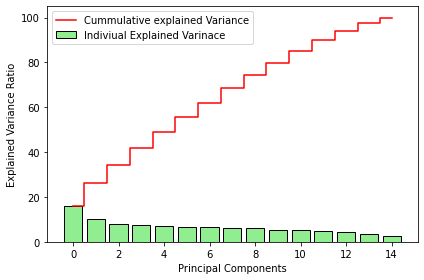

In [ ]:
plt.bar(range(15),var_exp, align='center',color='lightgreen',edgecolor='black',label='Indiviual Explained Varinace')
plt.step(range(15), cum_var_exp, where='mid',color='red',label='Cummulative explained Variance')
plt.legend(loc = 'best')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.tight_layout()
plt.show()

- We can see that approximately 80.0% of variance is explained by the first 10 variables.
- so, we can choose the optimal number of principal components as 10.

In [ ]:
pca=PCA(n_components = 10)
pca.fit(scaled_features_df)

PCA(n_components=10)

In [ ]:
data_pca = pca.transform(scaled_features_df)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.863405,1.616243,0.604286,0.780499,0.232403,0.167807,-0.638376,0.830357,0.769600,1.673673
1,0.740996,0.737776,0.073456,-0.660453,-0.309406,-0.091730,0.176715,-1.149435,0.736648,0.135785
2,1.333525,0.227786,1.413957,-0.097731,0.574525,0.628063,-1.699970,0.379289,-1.328221,-0.151213
3,1.620595,-0.491519,-0.219290,1.604197,0.079296,0.008933,-0.342345,-0.947008,0.121129,0.800066
4,-2.109267,-1.732279,0.101220,-0.623730,-0.175897,0.092863,0.280105,-0.719828,0.701509,-0.652690


## K-means Clustering

### Q15. Apply k-means and try to find the optimal number of clusters.

In [ ]:
cluster_range = range(1,15)
cluster_errors = []

for num_clusters in cluster_range:
   
    clusters = KMeans(num_clusters, n_init=10)
    clusters.fit(data_pca)
    
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({'num_clusters':cluster_range, 
                           'cluster_errors':cluster_errors})

clusters_df

,num_clusters,cluster_errors
0,1,24236.961659
1,2,20735.602434
2,3,18826.440311
3,4,17152.402192
4,5,16007.463051
5,6,14998.024625
6,7,13240.030487
7,8,12507.150590
8,9,11656.501075
9,10,11059.291520


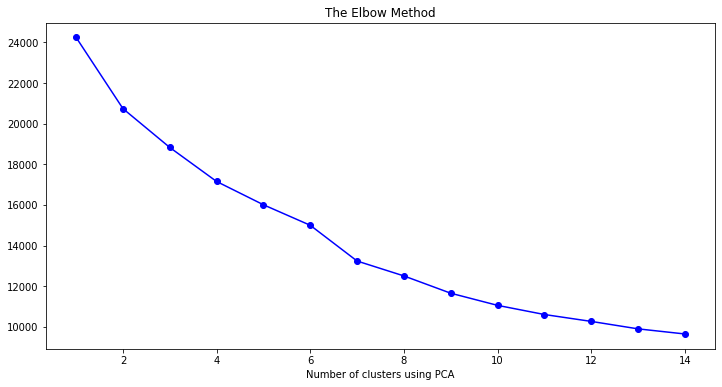

In [ ]:
## Elbow method
plt.figure(figsize=[12,6])
plt.title('The Elbow Method')
plt.xlabel('Number of clusters using PCA')
plt.plot(clusters_df['num_clusters'],clusters_df['cluster_errors'],marker='o',color='b')
plt.show()

- From the Elbow plot, we can see that at K=6 the interia starts to drop significantly. So we will do it using 6 clusters. 
- The clusters are labeled as 0,1,2,3,4,5.

In [ ]:
## Fit the KMeans clustering model using the obtained optimal K
kmeans = KMeans(n_clusters=6, n_init=15, random_state=2345)
kmeans.fit(data_pca)

KMeans(n_clusters=6, n_init=15, random_state=2345)

In [ ]:
## obtained labels from kmeans clustering
kmeans.labels_

array([2, 1, 1, ..., 4, 4, 3], dtype=int32)

In [ ]:
## Creating a new dataframe only for labels and converting it into categorical variables.
df_labels = pd.DataFrame(kmeans.labels_, columns=list(['Labels']))
df_labels.head(50)

,Labels
0,2
1,1
2,1
3,1
4,4
5,2
6,3
7,1
8,4
9,2


In [ ]:
df_labels['Labels'] = df_labels['Labels'].astype('category')

In [ ]:
## joining the label dataframe with unscaled initial dataframe.(df)

df_kmeans = df.join(df_labels)

df_kmeans.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,Labels
0,25,2,226802,1,7,4,6,3,2,1,0,0,40,31,0,2
1,38,2,89814,11,9,2,4,0,4,1,0,0,50,31,0,1
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,31,1,1
3,44,2,160323,15,10,2,6,0,2,1,7688,0,40,31,1,1
4,18,2,103497,15,10,4,3,3,4,0,0,0,30,31,0,4


In [ ]:
df_kmeans['Labels'].value_counts()

1    797
4    628
2    273
3    219
0     89
5     15
Name: Labels, dtype: int64

### Q16. Compute Silhoutte Score for validating the best optimal number of clusters.

In [ ]:
from sklearn.metrics import silhouette_score

kmeans_score = []

for i in range(2,15):
    kmeans = KMeans(n_clusters=i)
    kmeans = kmeans.fit(data_pca)
    labels = kmeans.predict(data_pca)
    print(i,silhouette_score(data_pca,labels))

2 0.1593919747525054
3 0.17112803588858805
4 0.18270553557022706
5 0.19523909170446027
6 0.16560029344549002
7 0.1834128447993938
8 0.19153032946293683
9 0.17518057470596937
10 0.17625187000731898
11 0.1549772018850891
12 0.1810649736701277
13 0.16499804690590508
14 0.16351587997656886


 - From above, we can observe that for 5 and 6 clusters the silhoutte score is highest, we can choose optimal clusters as 5 or 6.

## Agglomertaive Clustering

### Q17. Use dendrograms and find the number of classes in the dataset. 

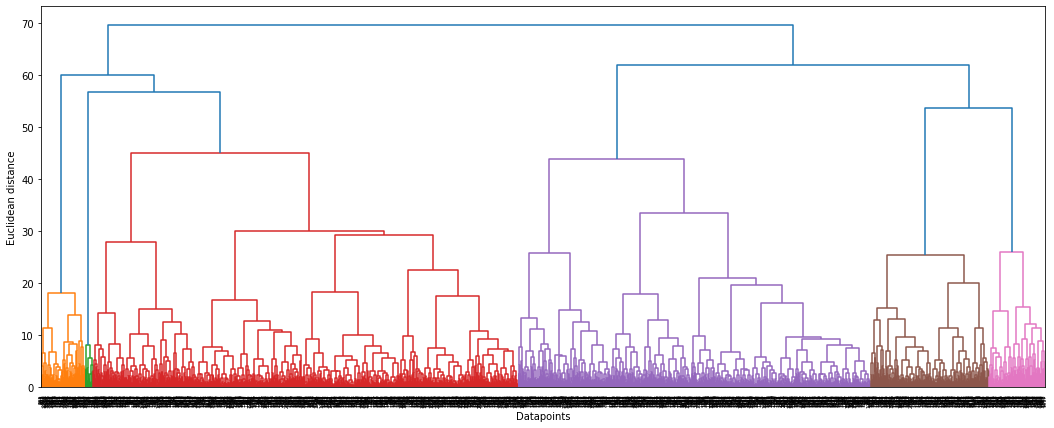

In [ ]:
plt.figure(figsize=[18,7])
merg = linkage(data_pca, method='ward')
dendrogram(merg, leaf_rotation=90,)
plt.xlabel('Datapoints')
plt.ylabel('Euclidean distance')
plt.show()

In [ ]:
## Building hierarchical clustering model using the optimal clusters as 4
hie_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean',
                                     linkage='ward')
hie_cluster_model = hie_cluster.fit(data_pca)

In [ ]:
## Creating a dataframe of the labels
df_label1 = pd.DataFrame(hie_cluster_model.labels_,columns=['Labels'])
df_label1.head(5)

,Labels
0,1
1,0
2,0
3,2
4,2


In [ ]:
## joining the label dataframe with unscaled initial dataframe.(df)

df_hier = df1.join(df_label1)
df_hier.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,Labels
0,25,2,226802,1,7,4,6,3,2,1,0,0,40,31,0,1
1,38,2,89814,11,9,2,4,0,4,1,0,0,50,31,0,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,31,1,0
3,44,2,160323,15,10,2,6,0,2,1,7688,0,40,31,1,2
4,18,2,103497,15,10,4,3,3,4,0,0,0,30,31,0,2


### Q18. Compute Silhoutte Score for validating the best optimal number of classes.

In [ ]:
for i in range(2,15):
    hier = AgglomerativeClustering(n_clusters=i)
    hier = hier.fit(data_pca)
    labels = hier.fit_predict(data_pca)
    print(i,silhouette_score(data_pca,labels))

2 0.11568625084502149
3 0.11895791012524085
4 0.13906880913741984
5 0.1462721918207638
6 0.16752252631122208
7 0.163056940918668
8 0.1655988657394359
9 0.14676124786433808
10 0.11792855939055359
11 0.1106400884418129
12 0.12055909485804847
13 0.12471476850848542
14 0.13189809619632611


- From above, we can observe that the silhouette score is highest for 6.

## Conclustion

- In this case study, we have attempted to cluster adult census dataset using K-means and agglomerative clustering and we also reduced the dimensionality of the dataset using PCA.
- We came up with 6 clusters using K-means and 4 classes using agglomerative clustering.
- Although selection of the clusters can be revised using Silhoutte score but for a general introductory part it is okay to visualize the plot (either elbow graph or dendrograms) and come up with a particular clusters size.
- Further, we can also do the cluster analysis by doing bivariate analysis between cluster labels and different features and understand the characteristics of different groups.

-----
## Happy Learning
-----